The goal of this home work is to design convolutional neural network for classification task on two dataset (a) cifar10 (b) Bricklane. As a part of this home work you will implement convolutional neural network in python and then study the effect of pooling, dropout, batch normalization and learning rate for given classifcation task. 
<br>
Please note:
- You have to save each trained model weights and tensorboard logs in different folder. Use proper names for the model
- You have to show trainings in this notebook file, so make sure that the printings and figures are available on this notebook file
- This notebook is also your report file. So add your comments and analysis of each task. This would be considered short report and it is compulsory part of the homework.
- Your system memory may overflow. In that case please reset memory for trained model(s) keeping printed logs and history of trained model. History of all trained models could be used to plot the trends.
- For trends you shall also use tensorboard logs 




#### imports

In [1]:
from keras.models import Model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau, TensorBoard
from keras.utils import plot_model, to_categorical
import keras.backend as K
from keras.datasets import cifar10
import keras
import os
from sklearn.model_selection import train_test_split
from IPython.display import display
import glob
import cv2
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import json
plt.style.use('seaborn')

#import seaborn as sns

import os
your_id = 19100243
np.random.seed(your_id)


Using TensorFlow backend.


###### Hyperparameters

In [2]:
batch_size = 16
num_classes = 10
class_labels = np.arange(0, num_classes, 1)
input_shape = (32,32,3)
images_dir = 'images/'
print("class labels: ",class_labels)

class labels:  [0 1 2 3 4 5 6 7 8 9]


##### Task 1.1   Load dataset information
[_cifar10_](https://www.cs.toronto.edu/~kriz/cifar.html) dataset contains 10 classes including airplane, bird, cat etc. You need to download dataset from [LINK](http://pjreddie.com/media/files/cifar.tgz) or [LINK2](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz). 
<br> _cifar10_ dataset is also available in keras but it is recommended to use the downloaded from above given link as ```cifar10.load_data()``` function downloads and loads complete data on RAM. 
<br> <br>
This [Github](https://github.com/EN10/CIFAR) link may be helpful to you to load _cifar10_ dataset yourself.


In [3]:
from numpy import array

def data_load(dir,labels):
    train_paths=[]
    train_labels=[]
    for x in range(num_classes):    #list directories according to the classes
#         print("labels: ",labels[x][:-1])
        paths = glob.glob(train_dir +'*'+ labels[x][:-1]+ '.png')
    #     print(paths)
        class_label=[x for i in range(len(paths))]
    #     print(class_label)
        train_paths+= paths
        train_labels+= class_label

#     print("train is: ", train_paths)
#     print("train labels: ",train_labels)
    return array(train_paths),array(train_labels)
    
    

In [ ]:

# The data, split between train and test sets:

train_dir = 'cifar/train/'
test_dir = 'cifar/test/'
with open('cifar/labels.txt', 'r') as f:
    labels = f.readlines()

x_train,y_train = data_load(train_dir,labels)
x_test,y_test = data_load(test_dir,labels)

# (x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=your_id)

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(y_train.shape, 'train samples')
print(x_test.shape[0], 'test samples')
print(x_test[0])
# print ("x_val: ",x_val[0])

##### Task 1.2 Preprocessing
Preprocessing of data such as normalization, mean shift, make the learning task simple for network and could accelrate the training process. 

###### Task 1.2.1 
For the images, pixel values vary from 0 to 255. To shift the values between (0,1) range, divide input image by 255. Now, retrain the model designed in part-A from scratch with preprocessed data. 

In [5]:
# You shall add your code here
def preprocessing_norm (images):
    #Add code here
#     print("images are: ",images)
    processed_images=images
    for image in processed_images:
        np.divide(image,255)
#         np.divide(image,float(255))
    return processed_images


###### Task 1.2.2
For the images, pixel values vary from 0 to 255. Compute the channel wise mean and standard daviation (std) for whole dataset. subtract channel-wise mean and divide by channel-wise std. This will shift the mean to zero and varation to 1. 

In [6]:
# You shall add your code here
def preprocessing_meanShift (images):
    #Add code here
    processed_images=images
    imgs=np.stack(images)
    mean = np.mean(images[:,:,:,0]),np.mean(images[:,:,:,1]),np.mean(images[:,:,:,2])
    std = np.std(images[:,:,:,0]),np.std(images[:,:,:,1]),np.std(images[:,:,:,2])
#     print ("mean is : ",mean)
    processed_images=(processed_images-mean)/std
    return processed_images


##### Task 1.3  Batch Generator
For the training, we load complete data (inputs, outputs) into RAM and then provide it to "model.fit" function. However, in real when dataset is very large in size we can not load complete data on RAM. In that case, we need load data batchwise. To do this, we need to write a generator function that shall load a batch of data (images and output), preprocess images and return a tuple as (inputs, outputs) on every step. 
<br>
- The template code for batch generator is provided. You need add you script to read image(s), labels and preprocessing of images. 
<br>
- You need to check and control values of batch_start and batch_end 
<br>
- Batch generator can be implemented in multiple ways. You can use any other template of your choice.

In [7]:
# You need to check and control values of batch_start and batch_end 

def data_generator(images_paths,label_file, batch_size = 64, preprocessing = None):
    batch_start = 0
    batch_end = batch_size
    n=len(label_file)
    indexes=np.arange(0,len(images_paths),batch_size)
#     print("indexes: ",indexes)
    
    if n % batch_size != 0:
        indexes = indexes[:-1] 
    
    
    while True:
        
        for b_start in indexes:
                
            image_pths = images_paths [b_start: b_start+batch_size]
            batch_lbls = label_file [b_start: b_start+batch_size]
            
            # Add your code here
            # Preprocessing is your choice. 
            batch_images=np.zeros((batch_size, *input_shape))
            batch_labels = np.zeros((batch_size, num_classes))

            count=0
            for path in image_pths:
                
                x=cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB)
#                 print("type: ",type(x[0][0][0]))
#                 x.astype(float)
                
                batch_images[count,:,:,:]=x
                
                labels= np.zeros((num_classes,),dtype='int')
                labels[batch_lbls[count]]=1
                batch_labels[count,:]=labels
                count+=1
            if (preprocessing is None):
                pass
            elif (preprocessing == 'method1'):
                batch_images = preprocessing_norm(batch_images)
            else:
                batch_images = preprocessing_meanShift(batch_images)
            
            yield(batch_images, batch_labels)
    
# data_generator(x_train, y_train, batch_size, preprocessing = None)

##### Task 1.4 Design CNN model

In [8]:
# Add your code here

input_im = Input(shape=(input_shape), name='input_im')
conv1 = Conv2D(8, kernel_size=(3, 3), strides = (2,2),  activation='relu')(input_im)
conv2 = Conv2D(16, (3, 3), strides = (2,2), activation='relu')(conv1)
flat = Flatten()(conv2)
dense1 = Dense(44, activation='relu')(flat)
output_class = Dense(num_classes, activation='softmax')(dense1)

model = Model(inputs=input_im, outputs=output_class)

##### Compile model and plot

In [9]:
model_name = 'id_model1'

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
    
adam = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

plot_model(model, model_name+'/'+model_name+'.png')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_im (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 8)         224       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 16)          1168      
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 44)                34540     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                450       
Total params: 36,382
Trainable params: 36,382
Non-trainable params: 0
_________________________________________________________________


##### Task 1.5 Training model
In order to train the model, instead of "model.fit" function, we will use "model.fit_generator" function for training. For details check out [keras documentation](https://keras.io/models/sequential/)

In [10]:
class LRTensorBoard(TensorBoard):
    def __init__(self, *args, **kwargs):
        super(LRTensorBoard, self).__init__(*args, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        logs.update({'lr': K.eval(self.model.optimizer.lr)})
        super(LRTensorBoard, self).on_epoch_end(epoch, logs)

In [15]:
epochs = 1
    
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, cvslogger, reducelr]

###### Task 1.5.1 
Train model without using any pre-processing scheme

In [16]:
train_gen = data_generator(x_train, y_train, batch_size, preprocessing = None)
val_gen = data_generator(x_val, y_val, batch_size)
test_gen = data_generator(x_test, y_test, batch_size)

In [ ]:
x,y= val_gen.__next__()
print(x,y)

In [18]:
hist1 = model.fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(y_train)//batch_size, 
                           validation_data=val_gen, validation_steps=len(y_val)//batch_size, 
                           callbacks=callbacks, verbose=1)

# save model
# with open('hist1.json', 'w') as f:
#     json.dump(hist1.history, f)

Epoch 1/1
2500/2500 [==============================] - 35s 14ms/step - loss: 1.7451 - acc: 0.3479 - val_loss: 1.6207 - val_acc: 0.4036

Epoch 00001: val_loss improved from inf to 1.62071, saving model to id_model1/id_model1-01-1.62.h5


###### Task 1.5.2 
Train model by using data preprocessing i.e normalization or mean shift. 

In [115]:
model= None
# Add your code here
input_im = Input(shape=(input_shape), name='input_im')
conv1 = Conv2D(8, kernel_size=(3, 3), strides = (2,2),  activation='relu')(input_im)
conv2 = Conv2D(16, (3, 3), strides = (2,2), activation='relu')(conv1)
flat = Flatten()(conv2)
dense1 = Dense(44, activation='relu')(flat)
output_class = Dense(num_classes, activation='softmax')(dense1)

model = Model(inputs=input_im, outputs=output_class)


model_name = 'model1_processing_norm'

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
    
adam = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

plot_model(model, model_name+'/'+model_name+'.png')
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_im (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 15, 15, 8)         224       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 7, 7, 16)          1168      
_________________________________________________________________
flatten_19 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 44)                34540     
_________________________________________________________________
dense_38 (Dense)             (None, 10)                450       
Total params: 36,382
Trainable params: 36,382
Non-trainable params: 0
_________________________________________________________________


In [ ]:

epochs = 5
    
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, cvslogger, reducelr]


#-----------------------------------------------

train_gen = data_generator(x_train, y_train, batch_size, preprocessing = 'method1')
val_gen = data_generator(x_val, y_val, batch_size)
test_gen = data_generator(x_test, y_test, batch_size)

x,y= val_gen.__next__()

hist2 = model.fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(y_train)//batch_size, 
                           validation_data=val_gen, validation_steps=len(y_val)//batch_size, 
                           callbacks=callbacks, verbose=1)

# save model

##### Task 2.1 Pooling
Now, you need to modify the model by adding pooling layer(s). Pooling could be average pooling or max pooling. You can use the size and stride for pooling of your choice. 
<br> 
Modify the network by introducing pooling layer and train the model using __fit_generator__ function. 

In [41]:
model = None
# Add your code here

input_im = Input(shape=(input_shape), name='input_im')
batch1=BatchNormalization()(input_im)
conv1 = Conv2D(8, kernel_size=(3, 3), strides = (2,2),  activation='relu')(batch1)
conv2 = Conv2D(16, (3, 3), strides = (2,2), activation='relu')(conv1)
pooled = MaxPooling2D(pool_size=(5, 5))(conv2)
flat = Flatten()(pooled)
dense1 = Dense(44, activation='relu')(flat)
output_class = Dense(num_classes, activation='softmax')(dense1)

model = Model(inputs=input_im, outputs=output_class)


# save model

In [42]:
model_name = 'model_pooling'

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
    
adam = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

plot_model(model, model_name+'/'+model_name+'.png')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_im (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 8)         224       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 7, 7, 16)          1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 16)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 44)                748       
__________

In [43]:
epochs = 5
    
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, cvslogger, reducelr]


In [44]:
#to train the pooling model
train_gen = data_generator(x_train, y_train, batch_size, preprocessing = None)
val_gen = data_generator(x_val, y_val, batch_size)
test_gen = data_generator(x_test, y_test, batch_size)

x,y= val_gen.__next__()

hist3 = model.fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(y_train)//batch_size, 
                           validation_data=val_gen, validation_steps=len(y_val)//batch_size, 
                           callbacks=callbacks, verbose=1)



Epoch 1/5
2500/2500 [==============================] - 35s 14ms/step - loss: 1.9553 - acc: 0.2682 - val_loss: 1.7863 - val_acc: 0.3333

Epoch 00001: val_loss improved from inf to 1.78628, saving model to model_pooling/model_pooling-01-1.79.h5
Epoch 2/5
2500/2500 [==============================] - 23s 9ms/step - loss: 1.7718 - acc: 0.3420 - val_loss: 1.7106 - val_acc: 0.3687

Epoch 00002: val_loss improved from 1.78628 to 1.71056, saving model to model_pooling/model_pooling-02-1.71.h5
Epoch 3/5
2500/2500 [==============================] - 23s 9ms/step - loss: 1.7166 - acc: 0.3678 - val_loss: 1.6778 - val_acc: 0.3864

Epoch 00003: val_loss improved from 1.71056 to 1.67775, saving model to model_pooling/model_pooling-03-1.68.h5
Epoch 4/5
2500/2500 [==============================] - 23s 9ms/step - loss: 1.6868 - acc: 0.3818 - val_loss: 1.6602 - val_acc: 0.3946

Epoch 00004: val_loss improved from 1.67775 to 1.66020, saving model to model_pooling/model_pooling-04-1.66.h5
Epoch 5/5
2500/2500

##### Task 3.1 Dropout
Modify the network by introducing dropout layer and train the model using __fit_generator__ function. 

In [71]:
model = None

# Add your code here


input_im = Input(shape=(input_shape), name='input_im')
conv1 = Conv2D(8, kernel_size=(3, 3), strides = (2,2),  activation='relu')(input_im)
conv2 = Conv2D(16, (3, 3), strides = (2,2), activation='relu')(conv1)
pooled = MaxPooling2D(pool_size=(2, 2))(conv2)
dropped = Dropout(rate=0.25)(pooled)
flat = Flatten()(dropped)
dense1 = Dense(44, activation='relu')(flat)
dropped2 = Dropout(rate=0.5)(dense1)
output_class = Dense(num_classes, activation='softmax')(dropped2)

model = Model(inputs=input_im, outputs=output_class)

# save model


In [72]:
model_name = 'model_dropout'

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
    
adam = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

plot_model(model, model_name+'/'+model_name+'.png')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_im (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 15, 15, 8)         224       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 7, 7, 16)          1168      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 3, 3, 16)          0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 3, 3, 16)          0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 144)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 44)                6380      
__________

In [73]:
epochs = 5
    
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, cvslogger, reducelr]

In [74]:
#to train the pooling model
train_gen = data_generator(x_train, y_train, batch_size, preprocessing = None)
val_gen = data_generator(x_val, y_val, batch_size)
test_gen = data_generator(x_test, y_test, batch_size)

x,y= val_gen.__next__()

hist4 = model.fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(y_train)//batch_size, 
                           validation_data=val_gen, validation_steps=len(y_val)//batch_size, 
                           callbacks=callbacks, verbose=1)

Epoch 1/5
2500/2500 [==============================] - 24s 9ms/step - loss: 2.8761 - acc: 0.1182 - val_loss: 2.1994 - val_acc: 0.1825

Epoch 00001: val_loss improved from inf to 2.19942, saving model to model_dropout/model_dropout-01-2.20.h5
Epoch 2/5
2500/2500 [==============================] - 22s 9ms/step - loss: 2.1229 - acc: 0.1948 - val_loss: 1.9320 - val_acc: 0.2716

Epoch 00002: val_loss improved from 2.19942 to 1.93196, saving model to model_dropout/model_dropout-02-1.93.h5
Epoch 3/5
2500/2500 [==============================] - 23s 9ms/step - loss: 1.9663 - acc: 0.2480 - val_loss: 1.8062 - val_acc: 0.3193

Epoch 00003: val_loss improved from 1.93196 to 1.80619, saving model to model_dropout/model_dropout-03-1.81.h5
Epoch 4/5
2500/2500 [==============================] - 24s 9ms/step - loss: 1.8981 - acc: 0.2800 - val_loss: 1.7892 - val_acc: 0.3348

Epoch 00004: val_loss improved from 1.80619 to 1.78924, saving model to model_dropout/model_dropout-04-1.79.h5
Epoch 5/5
2500/2500 

##### Task 4.1 Batch Normalization
Modify the network by introducing batch normalization layer and train the model. 

In [82]:
model = None

# Add your code to complete this cell

model_name = 'model_batch'
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
    
# ====================================================   
input_im = Input(shape=(input_shape), name='input_im')
b_Norm1=BatchNormalization(axis=-1,momentum=0.99, epsilon=0.001)(input_im)
# Hidden Layers
conv1 = Conv2D(8, kernel_size=(3, 3), strides = (2,2),  activation='relu')(b_Norm1)
b_Norm2=BatchNormalization(axis=-1,momentum=0.99, epsilon=0.001)(conv1)
pooled = MaxPooling2D(pool_size=(2, 2))(b_Norm2)
dropped = Dropout(rate=0.2)(pooled)


conv2 = Conv2D(16, (3, 3), strides = (2,2), activation='relu')(dropped)
b_Norm3=BatchNormalization(axis=-1,momentum=0.99, epsilon=0.001)(conv2)
pooled1 = MaxPooling2D(pool_size=(2, 2))(b_Norm3)
dropped1 = Dropout(rate=0.2)(pooled1)
flat = Flatten()(dropped1)

dense1 = Dense(44, activation='relu')(flat)

output_class = Dense(num_classes, activation='softmax')(dense1)
model = Model(inputs=input_im, outputs=output_class)
# ====================================================

adam = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])
plot_model(model, model_name+'/'+model_name+'.png')
model.summary()

# save model

# batch normalization changes the distribution of input values(covariance shift).

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_im (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 15, 15, 8)         224       
_________________________________________________________________
batch_normalization_12 (Batc (None, 15, 15, 8)         32        
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 3, 3, 16)          1168      
__________

In [83]:
epochs = 5
    
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, cvslogger, reducelr]

train_gen = data_generator(x_train, y_train, batch_size, preprocessing = 'method2')
val_gen = data_generator(x_val, y_val, batch_size)
test_gen = data_generator(x_test, y_test, batch_size)

x,y= val_gen.__next__()
hist_5 = model.fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(y_train)//batch_size, 
                           validation_data=val_gen, validation_steps=len(y_val)//batch_size, 
                           callbacks=callbacks, verbose=1)


Epoch 1/5
2500/2500 [==============================] - 44s 18ms/step - loss: 2.0113 - acc: 0.2453 - val_loss: 14.0188 - val_acc: 0.1127

Epoch 00001: val_loss improved from inf to 14.01884, saving model to model_batch/model_batch-01-14.02.h5
Epoch 2/5
2500/2500 [==============================] - 41s 16ms/step - loss: 1.8602 - acc: 0.3025 - val_loss: 12.7003 - val_acc: 0.1789

Epoch 00002: val_loss improved from 14.01884 to 12.70032, saving model to model_batch/model_batch-02-12.70.h5
Epoch 3/5
2500/2500 [==============================] - 37s 15ms/step - loss: 1.8057 - acc: 0.3275 - val_loss: 12.1941 - val_acc: 0.1955

Epoch 00003: val_loss improved from 12.70032 to 12.19409, saving model to model_batch/model_batch-03-12.19.h5
Epoch 4/5
2500/2500 [==============================] - 34s 14ms/step - loss: 1.7764 - acc: 0.3407 - val_loss: 11.5834 - val_acc: 0.2221

Epoch 00004: val_loss improved from 12.19409 to 11.58343, saving model to model_batch/model_batch-04-11.58.h5
Epoch 5/5
2500/25

##### Task 5.1 Comparision of all model

In this task you need to plot the loss and accuracy for all models and __discuss__ which model has better performance and why.   

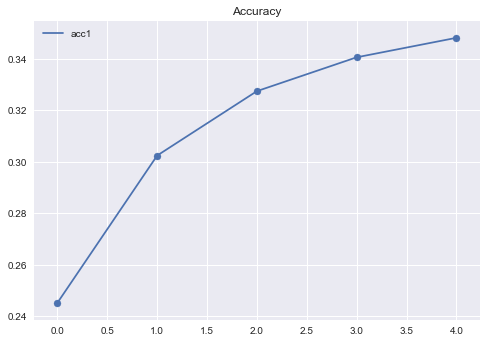

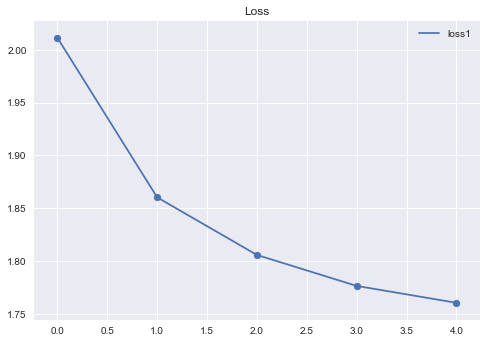

In [84]:
# plot Accuracy of all models
plt.clf() 
x_axis = list(range(epochs))
plt.plot(x_axis, hist_5.history['acc'], label='acc1')
plt.scatter(x_axis, hist_5.history['acc'])
# plt.plot(x_axis, hist2.history['acc'], label='acc2')
# print("check5")
# plt.scatter(x_axis, hist2.history['acc'])
plt.legend()
plt.title('Accuracy')
plt.show()

# plot loss of all models
plt.clf() 
x_axis = list(range(epochs))
plt.plot(x_axis, hist_5.history['loss'], label='loss1')
plt.scatter(x_axis, hist_5.history['loss'])
plt.legend()
plt.title('Loss')
plt.show()

###### Tensorboard 

You can run TensorBoard using the following command
```tensorboard --logdir=path/to/log-directory
```
Now for logs of all above trained models, take snapshot of the _loss_ and _accuracy_ plots and save in the directory where this notebook is. To show that saved plot here in notebook use following command in _markdown_ cell. 
<br> __![](path_to_image)__

- Tensorboard plot of accuracies:
!['loss'](loss.png)

- Tensorboard plot of accuracies:
!['Accuracy](acc.png)


###### ADD Your Comments here

##### Task 5.2 Visualize Activations
In this task, you are required to visualize the activations (outputs) of both the convolution layers of a model. For help, please refer to __Tutorials__

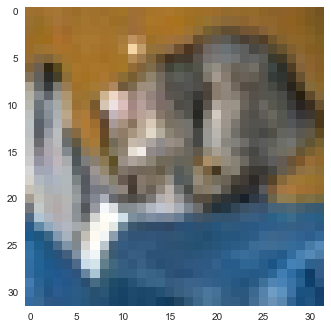

In [120]:
## ADD you code here

# new_model = Model(inputs=input_im, outputs=conv2)
# con1_activations = new_model.predict(x_test[0,:,:].reshape((1,32,32,3)))
# con1_activations.shape

_, (x_test, y_test) = cifar10.load_data()
plt.imshow(x_test[0,:,:]);
plt.gca().grid(False);

In [125]:
new_model = Model(inputs=input_im, outputs=conv2)
con1_activations = new_model.predict(x_test[0,:,:].reshape((1,32,32,3)))
con1_activations.shape

# fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(15,20), dpi=80)

# for i,ax in enumerate(axes.flatten()):
#     print("i is: ",i)
#     ax.imshow(con1_activations[0,:,:,i]);
#     ax.grid(False);
#     ax.axis('off');

(1, 7, 7, 16)

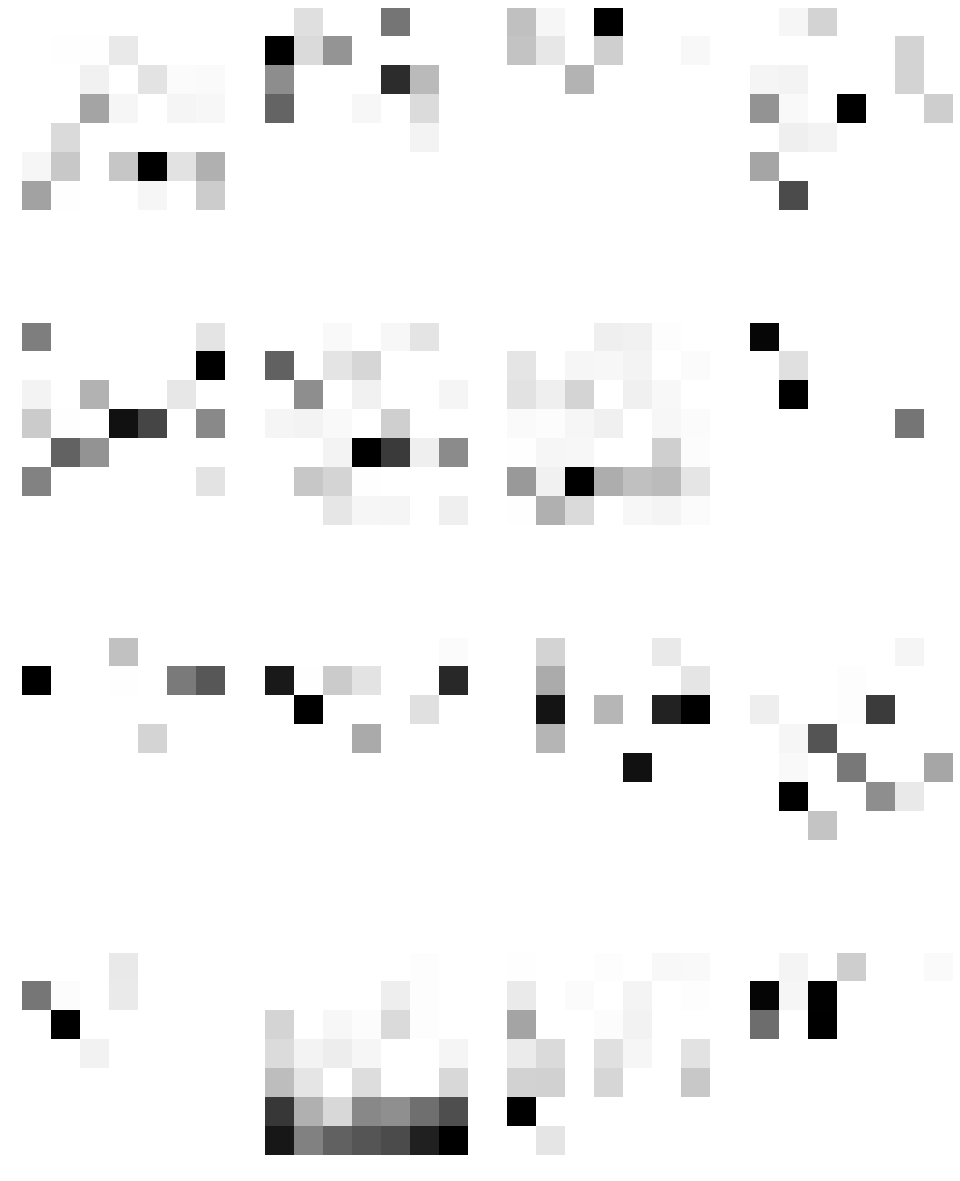

In [126]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15,20), dpi=80)

for i,ax in enumerate(axes.flatten()):
    ax.imshow(con1_activations[0,:,:,i]);
    ax.grid(False);
    ax.axis('off');

##### Task 6.1  Effect of learning rate

Take the best selected model in __Task 5.1__ and change its learning rate to: 
- 6.1.1 any value between 5 and 1.
- 6.1.2 learning rate = any value between 0.6 and  0.1 
- 6.1.3 learning rate = 0.00001

and train these three models to compare the effect learning rate.

In [130]:
# add your code here
model = None

# Add your code to complete this cell

model_name = 'model_batch'
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
    
# ====================================================   
input_im = Input(shape=(input_shape), name='input_im')
b_Norm1=BatchNormalization(axis=-1,momentum=0.99, epsilon=0.001)(input_im)
# Hidden Layers
conv1 = Conv2D(8, kernel_size=(3, 3), strides = (2,2),  activation='relu')(b_Norm1)
b_Norm2=BatchNormalization(axis=-1,momentum=0.99, epsilon=0.001)(conv1)
pooled = MaxPooling2D(pool_size=(2, 2))(b_Norm2)
dropped = Dropout(rate=0.2)(pooled)


conv2 = Conv2D(16, (3, 3), strides = (2,2), activation='relu')(dropped)
b_Norm3=BatchNormalization(axis=-1,momentum=0.99, epsilon=0.001)(conv2)
pooled1 = MaxPooling2D(pool_size=(2, 2))(b_Norm3)
dropped1 = Dropout(rate=0.2)(pooled1)
flat = Flatten()(dropped1)

dense1 = Dense(44, activation='relu')(flat)

output_class = Dense(num_classes, activation='softmax')(dense1)
model = Model(inputs=input_im, outputs=output_class)
# ====================================================

adam = Adam(lr=0.00001)
model.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])
plot_model(model, model_name+'/'+model_name+'.png')
model.summary()

# save model


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_im (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 15, 15, 8)         224       
_________________________________________________________________
batch_normalization_21 (Batc (None, 15, 15, 8)         32        
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 3, 3, 16)          1168      
__________

In [ ]:
epochs = 5
    
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, cvslogger, reducelr]

train_gen = data_generator(x_train, y_train, batch_size, preprocessing = 'method2')
val_gen = data_generator(x_val, y_val, batch_size)
test_gen = data_generator(x_test, y_test, batch_size)

x,y= val_gen.__next__()
hist_5 = model.fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(y_train)//batch_size, 
                           validation_data=val_gen, validation_steps=len(y_val)//batch_size, 
                           callbacks=callbacks, verbose=1)


###### Task 6.2 Plot loss and accuracy

Plot the loss and accracy for best model selected in task 5.1, and model trained in 6.1.1, 6.1.2 and 6.1.3 task. Give the detailed analysis of the effect of learning rate in your words and select the best learning rate for this problem.